## load data

In [72]:
# inspired by https://colab.research.google.com/github/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Item_based_Collaborative_Recommender_System_using_KNN.ipynb#scrollTo=lgyPInMAwQAv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [165]:
movies = pd.read_csv('./movies.csv')
movies_archive = movies.copy()
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [41]:
movies['genres']

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9742, dtype: object

In [42]:
def splitt(s):
    return s.split('|')

In [43]:
movies['genres'] = movies['genres'].apply(splitt)

In [44]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [45]:
# get_dummies does not work so well with column of lists
# so I am using my self-defined functions here to encode
# genres into numerical values
genres = set()
for x in movies['genres']:
    genres = genres.union(x)

genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [46]:
# we decided to not care about the movies lacking genre info
# build binary columns for genres
genres.remove('(no genres listed)')
genres_copy = {}

for x in genres:
    genres_copy[x] = []

drop = []
for index, row in movies.iterrows():
    current = row['genres']
    if not current:
        drop.append(index)
        continue
    for key in genres_copy:
        if key == '(no genres listed)':
            drop.append(index)
        if key in current:
            genres_copy[key].append(1)
        else:
            genres_copy[key].append(0)
movies = movies.drop(drop)
for key in genres_copy:
    movies[key] = genres_copy[key]
movies.head()

,movieId,title,genres,Fantasy,Children,Film-Noir,Musical,IMAX,Comedy,Western,...,Documentary,Mystery,Romance,Sci-Fi,Drama,War,Adventure,Animation,Action,Horror
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
movie_basic = movies[['movieId', 'title']] # look-up table for movie titles
movies = movies.drop(['title', 'genres'], axis = 1) # numerical df for genres

In [48]:
movie_basic.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [49]:
movies.head()

,movieId,Fantasy,Children,Film-Noir,Musical,IMAX,Comedy,Western,Crime,Thriller,Documentary,Mystery,Romance,Sci-Fi,Drama,War,Adventure,Animation,Action,Horror
0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [66]:
ratings = pd.read_csv('./ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [50]:
ratings.shape

(100836, 4)

In [51]:
movies.shape

(9742, 20)

In [52]:
refined_rating = ratings.groupby(by=['userId','movieId'], as_index=False).agg({"rating":"mean"})
refined_rating.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


## EDA

In [55]:
num_users = len(refined_rating['userId'].value_counts())
num_items = len(refined_rating['movieId'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the rating dataset: {}'.format(num_items))

Unique number of users in the dataset: 610
Unique number of movies in the rating dataset: 9724


In [75]:
rating_count_df = pd.DataFrame(refined_rating.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Text(0, 0.5, 'number of ratings')

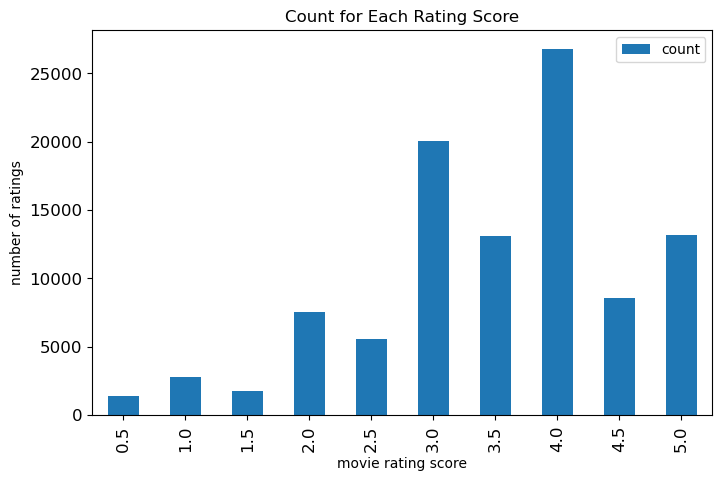

In [71]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(8, 5),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [73]:
total_count = num_items * num_users
zero_count = total_count - refined_rating.shape[0]
zero_count

5830804

In [78]:
# append counts of zero rating to df_ratings_cnt
rating_count_df = pd.concat([rating_count_df,
    pd.DataFrame({'count': zero_count}, index = [0.0])],
    verify_integrity = True,
).sort_index()
rating_count_df

,count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [79]:
# add log count
rating_count_df['log_count'] = np.log(rating_count_df['count'])
rating_count_df

,count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


In [80]:
rating_count_df = rating_count_df.reset_index().rename(columns={'index': 'rating score'})
rating_count_df

,rating score,count,log_count
0,0.0,5830804,15.578665
1,0.5,1370,7.222566
2,1.0,2811,7.941296
3,1.5,1791,7.490529
4,2.0,7551,8.929435
5,2.5,5550,8.621553
6,3.0,20047,9.905835
7,3.5,13136,9.483112
8,4.0,26818,10.196829
9,4.5,8551,9.053804


Text(0, 0.5, 'number of ratings')

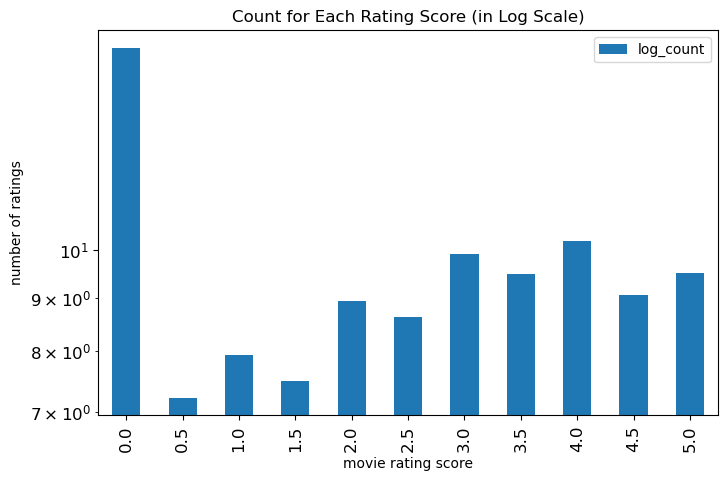

In [81]:
ax = rating_count_df.plot('rating score', 'log_count', 'bar', figsize=(8,5),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [83]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_rating.groupby('movieId').size(), columns=['count'])
movies_count_df.head(20)

,count
movieId,
1,215
2,110
3,52
4,7
5,49
6,102
7,54
8,8
9,16


Text(0, 0.5, 'number of ratings')

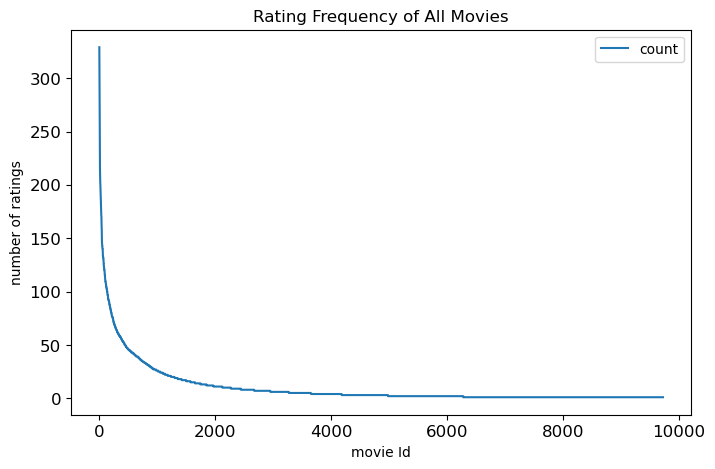

In [84]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(8, 5),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

## pivot

In [85]:
# pivot and create movie-user matrix
user_to_movie_df = refined_rating.pivot(
    index='userId',
     columns='movieId',
      values='rating').fillna(0)

user_to_movie_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

## fit knn model

In [87]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [95]:
## function to find top n similar users of the given input user 
def get_similar_users(user, n = 5):
    ## input to this function is the user and number of top similar users you want.

    knn_input = np.asarray([user_to_movie_df.values[user - 1]])  #.reshape(1,-1)
    # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors = n+1)
  
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")
    for i in range(1,len(distances[0])):
        print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    return indices.flatten()[1:] + 1, distances.flatten()[1:]

In [100]:
from pprint import pprint
user_id = 569
print(" Few of movies seen by the User:")
pprint(list(refined_rating[refined_rating['userId'] == user_id]['movieId'])[:10])
similar_user_list, distance_list = get_similar_users(user_id, 5)

 Few of movies seen by the User:
[10, 50, 153, 165, 185, 231, 296, 316, 329, 344]
Top 5 users who are very much similar to the User- 569 are: 
 
1 . User: 374 separated by distance of 0.3879034336966197
2 . User: 145 separated by distance of 0.3880591092209582
3 . User: 340 separated by distance of 0.41254448595120496
4 . User: 126 separated by distance of 0.41272736910158103
5 . User: 485 separated by distance of 0.4192583010517631


### take a look at two similar users

In [103]:
df569 = ratings.loc[ratings['userId'] == 569]
df569

,userId,movieId,rating,timestamp
88199,569,10,4.0,849190709
88200,569,50,3.0,849190709
88201,569,153,5.0,849190609
88202,569,165,5.0,849190610
88203,569,185,4.0,849190739
88204,569,231,3.0,849190632
88205,569,296,5.0,849190587
88206,569,316,4.0,849190633
88207,569,329,5.0,849190653
88208,569,344,4.0,849190609


In [104]:
df374 = ratings.loc[ratings['userId'] == 374]
df374

,userId,movieId,rating,timestamp
56464,374,110,5.0,849089153
56465,374,150,3.0,849089035
56466,374,153,4.0,849089070
56467,374,161,4.0,849089153
56468,374,165,3.0,849089070
56469,374,185,3.0,849089153
56470,374,208,3.0,849089153
56471,374,231,4.0,849089104
56472,374,296,5.0,849089035
56473,374,316,3.0,849089103


In [105]:
common = set(df569['movieId']).intersection(set(df374['movieId']))
df569_ = df569.loc[df569['movieId'].isin(common)]
df374_ = df374.loc[df374['movieId'].isin(common)]

In [106]:
df569_.merge(df374_, on = 'movieId')

,userId_x,movieId,rating_x,timestamp_x,userId_y,rating_y,timestamp_y
0,569,153,5.0,849190609,374,4.0,849089070
1,569,165,5.0,849190610,374,3.0,849089070
2,569,185,4.0,849190739,374,3.0,849089153
3,569,231,3.0,849190632,374,4.0,849089104
4,569,296,5.0,849190587,374,5.0,849089035
5,569,316,4.0,849190633,374,3.0,849089103
6,569,329,5.0,849190653,374,3.0,849089125
7,569,344,4.0,849190609,374,4.0,849089070
8,569,349,4.0,849190632,374,3.0,849089103
9,569,356,3.0,849190633,374,4.0,849089103


User 569 and User 374 indeed have similar taste

### some tryout & draft

In [107]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.19198458, 0.19206162, 0.20418014, 0.20427066, 0.207503  ])

In [108]:
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [109]:
movies_list = user_to_movie_df.columns
movies_list

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            193565, 193567, 193571, 193573, 193579, 193581, 193583, 193585,
            193587, 193609],
           dtype='int64', name='movieId', length=9724)

In [110]:
print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 9724)
Number of movies: 9724


In [111]:
weightage_list[:,np.newaxis]

array([[0.19198458],
       [0.19206162],
       [0.20418014],
       [0.20427066],
       [0.207503  ]])

In [112]:
np.zeros(len(movies_list))

array([0., 0., 0., ..., 0., 0., 0.])

In [113]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 9724)

In [115]:
(weightage_list[:,np.newaxis] + np.ones(len(movies_list)))[0][:20]

array([[1.19198458, 1.19198458, 1.19198458, ..., 1.19198458, 1.19198458,
        1.19198458]])

In [116]:
new_rating_matrix = weightage_list * mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([1.02090071, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [126]:
np.where(mean_rating_list == 0)[0][-1]

9723

In [138]:
sortd_index = np.argsort(mean_rating_list)[::-1]
sortd_index

array([9723, 9722, 9721, ..., 6360, 6359,    0])

In [134]:
mean_rating_list_sored = sorted(mean_rating_list)[::-1]

In [135]:
mean_rating_list_sored[0]

2.9577460105344624

In [137]:
mean_rating_list_sored[1]

2.6160760988055096

In [139]:
mean_rating_list[9723]

2.9577460105344624

In [154]:
mean_rating_list = mean_rating_list / (1 + np.log(1 + popular / 3))

In [155]:
mean_rating_list

array([0.        , 0.        , 0.        , ..., 1.55118871, 2.03161646,
       2.29695363])

In [158]:
movie_list = list(user_to_movie_df.columns)

In [159]:
[movie_list[i] for i in [7809, 4606, 1548, 793, 827, 7576]]

[93008, 6873, 2085, 1036, 1089, 86487]

# Recommender

we build a recommender based on collaborative filtering.

reweight the movies by popularity (number of ratings, movies getting more votes will be weighted down more)

If there is not enough movies, we simply add most popular movies to the tail of the recommended list

where `popularity` is meatured by sum of ratings received by the movie.

In [160]:
# movie list
movie_list = list(user_to_movie_df.columns)

In [121]:
# popularity table for reweighting purpose
popular = ratings.groupby(by=['movieId'], as_index=False).agg({"userId":"count"})
popular = np.array(popular[['userId']])
popular = np.reshape(popular, (len(popular))) # a 1D np.array of length = # rated movies

In [148]:
# best movies to recommend whenever there is not enough movies to recommend by CF
best = ratings.groupby(by=['movieId'], as_index=False).agg({"rating":"sum"})
best = best.sort_values(by = 'rating', ascending = False)

In [150]:
best.head()

,movieId,rating
277,318,1404.0
314,356,1370.0
257,296,1288.5
1938,2571,1165.5
510,593,1161.0


In [173]:
def recommender_system(user_id, n_similar_users = 5, n_movies = 10): #, user_to_movie_df, knn_model):
    
    # transfer movieIds to movie titles
    def get_names(l):
        # input: a list of movie ids
        # output: a list of corresponding movie names
        return list(movie_basic.loc[movie_basic['movieId'].isin(l)]['title'])
    
    # print history of the specified user 
    print("Movie seen by the User:") 
    watched_id = list(refined_rating[refined_rating['userId'] == user_id]['movieId']) # movie ids
    watched_name = get_names(watched_id) # movie names
    pprint(movies_archive.loc[movies_archive['movieId'].isin(watched_id)][['title', 'genres']])
    #pprint(watched_name[:min(len(watched_name), 10)]) # print at most 10 just for reference
    print("")

    ## function to find top n similar users of the given input user 
    def get_similar_users(user, n = n_similar_users):
        ## input to this function is the user and number of top similar users you want.

        knn_input = np.asarray([user_to_movie_df.values[user - 1]])  #.reshape(1,-1)
        # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
        distances, indices = knn_model.kneighbors(knn_input, n_neighbors = n+1)
  
        print("Top", n, "users who are very much similar to the User-", user, "are: ")
        print(" ")
        for i in range(1,len(distances[0])):
            print(i, ". User:", indices[0][i]+1, "separated by distance of", distances[0][i])
        return indices.flatten()[1:] + 1, distances.flatten()[1:]
    
    # get similar users and the movies they like
    similar_user_list, distance_list = get_similar_users(user_id, n_similar_users)
    mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
    # give more weight to more similar users
    weightage_list = np.exp(1 - distance_list)/np.sum(np.exp(1 - distance_list))
    weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
    new_rating_matrix = weightage_list * mov_rtngs_sim_users
    mean_rating_list = new_rating_matrix.sum(axis = 0) # initial weights
    
    # reweight by lower weights of popular items
    lower_bnd_ratings = 3
    mean_rating_list = mean_rating_list / (1 + np.log(1 + popular / lower_bnd_ratings))
    
    # get corresponding movie Ids from their indices in user_to_movie matrix
    def get_ids(indices):
        return [movie_list[i] for i in indices]

    def filtered_movie_recommendations(n = n_movies):
  
        #first_zero_index = np.where(mean_rating_list == 0)[0][-1]
        sortd_index = np.argsort(mean_rating_list)[::-1]
        mean_rating_list_sorted = sorted(mean_rating_list)[::-1]
        #sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
        count = 0
        indices = []
        for index, weight in zip(sortd_index, mean_rating_list_sorted):
            if count >= 2 * n or weight == 0: # 2*n: leave some room for already watched movies
                break
            indices.append(index)
            count += 1

        ids = get_ids(indices) # + list(best.head(n - count)['movieId'])
        
        # filter out the already watched movies
        count = 0
        filtered_ids = []
        for x in ids:
            if count >= n:
                break
            if x not in watched_id:
                filtered_ids.append(x)
                count += 1
        
        # if not enough movie in current filtered movie list built upon CF
        # we add popular movies
        remain = n - count
        for index, row in best.iterrows():
            if remain <= 0:
                break
            if row['movieId'] in filtered_ids or row['movieId'] in watched_id:
                continue
            filtered_ids.append(row['movieId'])
            remain -= 1
        
        pprint(movies_archive.loc[movies_archive['movieId'].isin(filtered_ids)][['title', 'genres']])

    print("")
    print("Movies recommended based on similar users are: ")
    print("")
    filtered_movie_recommendations(n_movies)

## tryout on some users

In [193]:
recommender_system(100)

Movie seen by the User:
                                       title                          genres
2                    Grumpier Old Men (1995)                  Comedy|Romance
10            American President, The (1995)            Comedy|Drama|Romance
15                             Casino (1995)                     Crime|Drama
16              Sense and Sensibility (1995)                   Drama|Romance
18     Ace Ventura: When Nature Calls (1995)                          Comedy
...                                      ...                             ...
4566  Seven Brides for Seven Brothers (1954)  Comedy|Musical|Romance|Western
4614              Intolerable Cruelty (2003)                  Comedy|Romance
4797           Something's Gotta Give (2003)            Comedy|Drama|Romance
5223                    Terminal, The (2004)            Comedy|Drama|Romance
5260                     Spider-Man 2 (2004)    Action|Adventure|Sci-Fi|IMAX

[148 rows x 2 columns]

Top 5 users who are very mu

In [194]:
recommender_system(589)

Movie seen by the User:
                                               title  \
24                          Leaving Las Vegas (1995)   
33                           Dead Man Walking (1995)   
98                                Taxi Driver (1976)   
123                                 Apollo 13 (1995)   
134                              Crimson Tide (1995)   
156                                  Net, The (1995)   
163                                 Showgirls (1995)   
197           Dumb & Dumber (Dumb and Dumber) (1994)   
201                                   Ed Wood (1994)   
210                               Hoop Dreams (1994)   
244                                      Nell (1994)   
257                              Pulp Fiction (1994)   
260                                 Quiz Show (1994)   
277                 Shawshank Redemption, The (1994)   
295               What's Eating Gilbert Grape (1993)   
300                          Muriel's Wedding (1994)   
308                     

### It looks that the recommendations make some sense according to genres.

In this project, movies liked by more similar users got higher weights. And if they are too popular (too many votes), then they are reweighted down by a bit. For future modification, we can do more with ranking. 